In [20]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Loading the dataset

df = pd.read_csv('Apache_2k_modified.csv')

In [4]:
df.head()

,LineId,Time,Level,Content,EventId,EventTemplate
0,1,Sun Dec 04 04:47:44 2005,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...,workerEnv.init\(\) ok <*>,workerEnv.init() ok <*>
1,2,Sun Dec 04 04:47:44 2005,error,mod_jk child workerEnv in error state 6,mod_jk child workerEnv in error state <*>,mod_jk child workerEnv in error state <*>
2,3,Sun Dec 04 04:51:08 2005,notice,jk2_init() Found child 6725 in scoreboard slot 10,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
3,4,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6726 in scoreboard slot 8,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
4,5,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6728 in scoreboard slot 6,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>


In [5]:
df.isnull().sum()

LineId           0
Time             0
Level            0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [6]:
len(df)

2000

In [7]:
df = df.drop_duplicates()

In [8]:
len(df)

2000

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [10]:
label_encoder = LabelEncoder()
df['Level_encoded'] = label_encoder.fit_transform(df['Level'])

In [11]:
tfidf = TfidfVectorizer(max_features=100)
content_tfidf = tfidf.fit_transform(df['Content']).toarray()
X = np.hstack((df[['Level_encoded']].values, content_tfidf))

In [30]:
# Bagging with multiple anomaly detectors

iso_forest = IsolationForest(contamination=0.01, random_state=42)
lof = LocalOutlierFactor(n_neighbors=10)
ocsvm = OneClassSVM(kernel='rbf', nu=0.01)

In [31]:
# Fit the models
iso_forest.fit(X)
lof.fit(X)
ocsvm.fit(X)

# Predicting anomalies
iso_pred = iso_forest.predict(X)
lof_pred = lof.fit_predict(X)
ocsvm_pred = ocsvm.predict(X)

/home/kairaj5456/.local/bin/new/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/kairaj5456/.local/bin/new/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [32]:
# Majority Voting for Final Decision
final_pred = np.sign(iso_pred + lof_pred + ocsvm_pred)
final_pred[final_pred > 0] = 1   # Majority is normal
final_pred[final_pred <= 0] = -1  # Majority is anomaly

In [33]:
# Convert to binary labels (1 for normal, 0 for anomaly)
combined_labels = np.array([1 if p == 1 else 0 for p in final_pred])

In [34]:
# For scoring, we need to compute anomaly scores for each model
iso_scores = iso_forest.decision_function(X)
lof_scores = lof.negative_outlier_factor_  # LOF gives negative outlier factors
ocsvm_scores = ocsvm.decision_function(X)

In [35]:
# Combine scores by averaging the scores
combined_scores = (iso_scores + lof_scores + ocsvm_scores) / 3

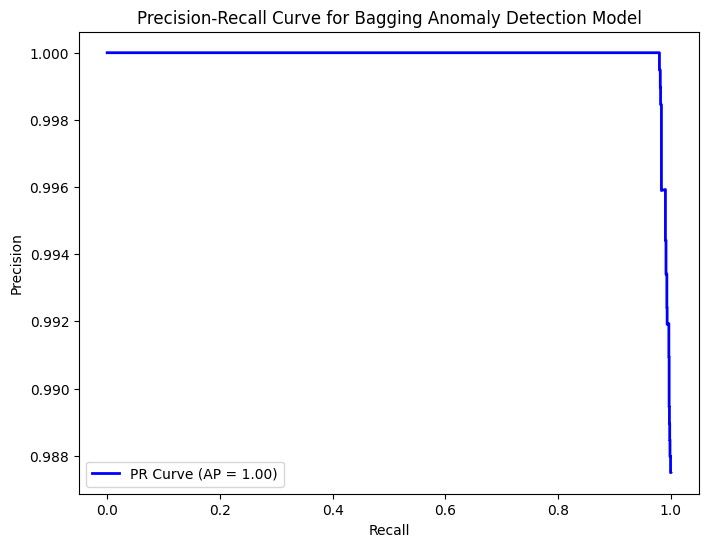

Average Precision (AP): 1.000


In [47]:
# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Bagging Anomaly Detection Model')
plt.legend(loc="lower left")
plt.show()

# Print Average Precision
print(f"Average Precision (AP): {average_precision:.3f}")


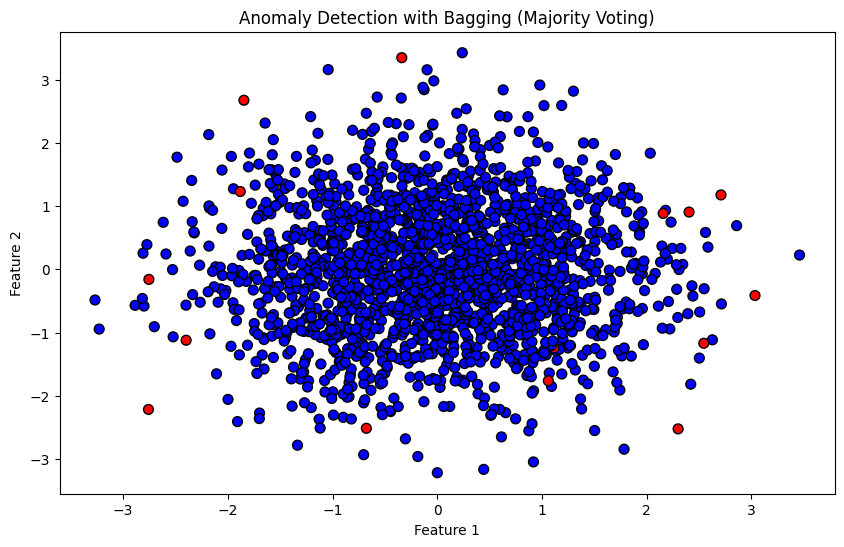

Silhouette Score for Majority Voting Model: 0.40804269663536885


In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Step 1: Fit individual anomaly detection models
iso_forest = IsolationForest(contamination=0.01, random_state=42)
lof = LocalOutlierFactor(n_neighbors=10)
ocsvm = OneClassSVM(kernel='rbf', nu=0.01)

# Fit the models
iso_forest.fit(X)
lof.fit(X)
ocsvm.fit(X)

# Step 2: Predicting anomalies
iso_pred = iso_forest.predict(X)  # -1 for anomalies, 1 for normal
lof_pred = lof.fit_predict(X)     # -1 for anomalies, 1 for normal
ocsvm_pred = ocsvm.predict(X)     # -1 for anomalies, 1 for normal

# Step 3: Majority Voting for Final Decision
# Combine predictions: -1 is anomaly, 1 is normal
final_pred = np.sign(iso_pred + lof_pred + ocsvm_pred)
final_pred[final_pred > 0] = 1  # Majority is normal
final_pred[final_pred <= 0] = -1  # Majority is anomaly

# Step 4: Plot all points, coloring based on anomaly detection
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=np.where(final_pred == -1, 'red', 'blue'), edgecolors='k', s=50)

# Set title and labels
plt.title("Anomaly Detection with Bagging (Majority Voting)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Display the plot
plt.show()

# Optionally, calculate silhouette score for the final model
from sklearn.metrics import silhouette_score

labels_combined = [1 if p == 1 else 0 for p in final_pred]
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X, labels_combined)
    print("Silhouette Score for Majority Voting Model:", silhouette_final)


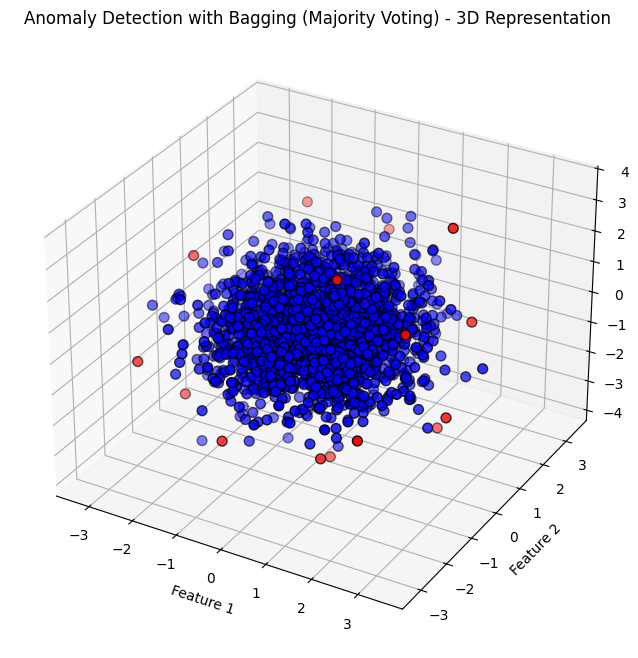

Silhouette Score for Majority Voting Model: 0.40804269663536885


In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Step 1: Fit individual anomaly detection models
iso_forest = IsolationForest(contamination=0.01, random_state=42)
lof = LocalOutlierFactor(n_neighbors=10)
ocsvm = OneClassSVM(kernel='rbf', nu=0.01)

# Fit the models
iso_forest.fit(X)
lof.fit(X)
ocsvm.fit(X)

# Step 2: Predicting anomalies
iso_pred = iso_forest.predict(X)  # -1 for anomalies, 1 for normal
lof_pred = lof.fit_predict(X)     # -1 for anomalies, 1 for normal
ocsvm_pred = ocsvm.predict(X)     # -1 for anomalies, 1 for normal

# Step 3: Majority Voting for Final Decision
# Combine predictions: -1 is anomaly, 1 is normal
final_pred = np.sign(iso_pred + lof_pred + ocsvm_pred)
final_pred[final_pred > 0] = 1  # Majority is normal
final_pred[final_pred <= 0] = -1  # Majority is anomaly

# Step 4: Plot all points in 3D, coloring based on anomaly detection
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal points in blue, anomalies in red
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.where(final_pred == -1, 'red', 'blue'), edgecolors='k', s=50)

# Set title and labels
ax.set_title("Anomaly Detection with Bagging (Majority Voting) - 3D Representation")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Display the plot
plt.show()

# Optionally, calculate silhouette score for the final model
from sklearn.metrics import silhouette_score

labels_combined = [1 if p == 1 else 0 for p in final_pred]
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X, labels_combined)
    print("Silhouette Score for Majority Voting Model:", silhouette_final)


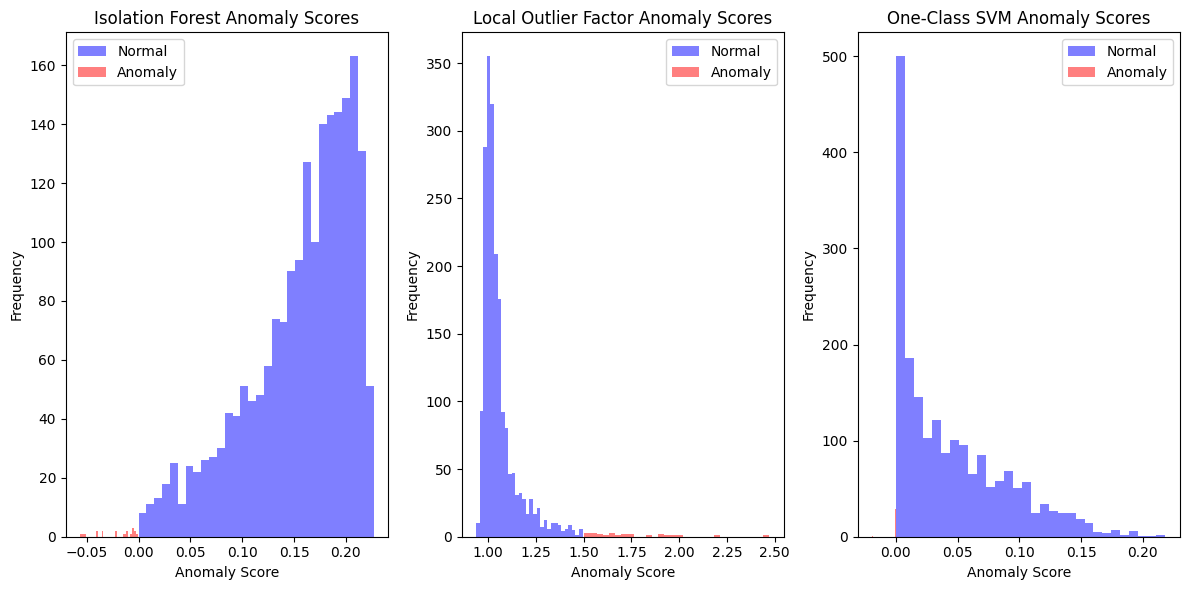

In [53]:
# Assuming you have the anomaly scores for each model:
# For Isolation Forest
iso_scores = iso_forest.decision_function(X)

# For LOF (negative is anomaly, so we flip the sign to make positive = anomaly)
lof_scores = -lof.negative_outlier_factor_

# For One-Class SVM (1 is normal, -1 is anomaly, so we take the decision function)
ocsvm_scores = ocsvm.decision_function(X)

# Plot histograms of the scores
plt.figure(figsize=(12, 6))

# Histogram of scores for Isolation Forest
plt.subplot(131)
plt.hist(iso_scores[iso_pred == 1], bins=30, alpha=0.5, label='Normal', color='blue')
plt.hist(iso_scores[iso_pred == -1], bins=30, alpha=0.5, label='Anomaly', color='red')
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

# Histogram of scores for LOF
plt.subplot(132)
plt.hist(lof_scores[lof_pred == 1], bins=30, alpha=0.5, label='Normal', color='blue')
plt.hist(lof_scores[lof_pred == -1], bins=30, alpha=0.5, label='Anomaly', color='red')
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

# Histogram of scores for One-Class SVM
plt.subplot(133)
plt.hist(ocsvm_scores[ocsvm_pred == 1], bins=30, alpha=0.5, label='Normal', color='blue')
plt.hist(ocsvm_scores[ocsvm_pred == -1], bins=30, alpha=0.5, label='Anomaly', color='red')
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()
